In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import zipfile
import cv2
from PIL import Image
import pickle
import warnings
import pathlib
import shutil
import random
import re
from pathlib import Path
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DRIVE_ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/Assignment/FruitsFreshAndRottenForClassification.zip"

In [ ]:
LOCAL_DATA_ROOT = "/content/data"
os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)

In [ ]:
print("Unzipping…")
with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as zf:
    zf.extractall(LOCAL_DATA_ROOT)

Unzipping…


In [ ]:
candidates = [d for d in pathlib.Path(LOCAL_DATA_ROOT).iterdir() if d.is_dir()]
SRC_ROOT = max(candidates, key=lambda d: sum(1 for _ in d.rglob("*"))) if candidates else pathlib.Path(LOCAL_DATA_ROOT)
print("Detected dataset root:", SRC_ROOT)

# Peek the structure
!find "$SRC_ROOT" -maxdepth 2 -type d -print | sed 's/^/DIR: /'

Detected dataset root: /content/data/dataset
DIR: /content/data/dataset
DIR: /content/data/dataset/dataset
DIR: /content/data/dataset/dataset/train
DIR: /content/data/dataset/dataset/test
DIR: /content/data/dataset/train
DIR: /content/data/dataset/train/freshbanana
DIR: /content/data/dataset/train/freshapples
DIR: /content/data/dataset/train/rottenoranges
DIR: /content/data/dataset/train/rottenbanana
DIR: /content/data/dataset/train/rottenapples
DIR: /content/data/dataset/train/freshoranges
DIR: /content/data/dataset/test
DIR: /content/data/dataset/test/freshbanana
DIR: /content/data/dataset/test/freshapples
DIR: /content/data/dataset/test/rottenoranges
DIR: /content/data/dataset/test/rottenbanana
DIR: /content/data/dataset/test/rottenapples
DIR: /content/data/dataset/test/freshoranges


In [ ]:
img_exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

# collect images that contain "fresh" or "rotten" in their path
all_paths = []
for pth in SRC_ROOT.rglob("*"):
    if pth.suffix.lower() in img_exts:
        s = str(pth)
        if re.search(r"fresh", s, re.I) or re.search(r"rotten|stale", s, re.I):
            all_paths.append(str(pth))
print("Total candidate images:", len(all_paths))

def label_from_path(p):
    return "fresh" if re.search(r"fresh", p, re.I) else "rotten"

label_buckets = {"fresh": [], "rotten": []}
for p in all_paths:
    label_buckets[label_from_path(p)].append(p)

for k in label_buckets:
    random.shuffle(label_buckets[k])
    print(f"{k}: {len(label_buckets[k])}")

# 80/10/10 stratified split
splits = {}
for cls, paths in label_buckets.items():
    n = len(paths); n_train, n_val = int(0.8*n), int(0.1*n)
    splits[cls] = {
        "train": paths[:n_train],
        "val":   paths[n_train:n_train+n_val],
        "test":  paths[n_train+n_val:]
    }

# materialize to /content/binary
BIN_ROOT = "/content/binary"
for split in ("train","val","test"):
    for cls in ("fresh","rotten"):
        os.makedirs(os.path.join(BIN_ROOT, split, cls), exist_ok=True)

def safe_copy(src, dst_dir):
    base = os.path.join(dst_dir, os.path.basename(src))
    name, ext = os.path.splitext(base)
    c, dst = 1, base
    while os.path.exists(dst):
        dst = f"{name}_{c}{ext}"; c += 1
    shutil.copy2(src, dst)

for cls, parts in splits.items():
    for split, paths in parts.items():
        outdir = os.path.join(BIN_ROOT, split, cls)
        for p in paths:
            safe_copy(p, outdir)

!for d in /content/binary/*/*; do echo $(ls "$d" | wc -l) images in $d; done


Total candidate images: 27198
fresh: 11808
rotten: 15390
4728 images in /content/binary/test/fresh
6156 images in /content/binary/test/rotten
37784 images in /content/binary/train/fresh
49248 images in /content/binary/train/rotten
4720 images in /content/binary/val/fresh
6156 images in /content/binary/val/rotten


In [ ]:
assert 'SRC_ROOT' in globals(), "Run the unzip cell first to set SRC_ROOT"

# --- SETTINGS for stability ---
IMG_SIZE = (192, 192)     # smaller than 224 = less RAM/compute
BATCH_SIZE = 16           # reduce if you still crash (try 8)
SHUFFLE_BUF = 512         # small shuffle buffer
PREFETCH = 1              # keep prefetch tiny to avoid RAM spikes
SEED = 42

# Count files by pattern, no loading:
def count_glob(patterns):
    n = 0
    for pat in patterns:
        n += sum(1 for _ in Path('.').glob(pat))
    return n

# Build glob patterns for fresh/rotten across the extracted tree
# We match any folder path containing "fresh" / "rotten" (case-insensitive)
root = Path(SRC_ROOT)
fresh_patterns  = [str(root / "**" / "*fresh*" / "*"), str(root / "**" / "*Fresh*" / "*")]
rotten_patterns = [str(root / "**" / "*rotten*" / "*"), str(root / "**" / "*Rotten*" / "*"),
                   str(root / "**" / "*stale*" / "*"),  str(root / "**" / "*Stale*" / "*")]

# Get lists of files (lazy) using tf.io.gfile.glob; then filter common image exts
IMG_EXT = (".jpg",".jpeg",".png",".bmp",".webp",".JPG",".JPEG",".PNG",".BMP",".WEBP")
def collect_files(patterns):
    files = []
    for pat in patterns:
        files += tf.io.gfile.glob(pat)
    files = [f for f in files if f.endswith(IMG_EXT)]
    random.Random(SEED).shuffle(files)
    return files

fresh_files  = collect_files(fresh_patterns)
rotten_files = collect_files(rotten_patterns)

print("fresh:", len(fresh_files), "| rotten:", len(rotten_files))

# --- Split 80/10/10 without copying (by indices) ---
def split_list(files):
    n = len(files)
    n_train = int(0.8*n)
    n_val   = int(0.1*n)
    return files[:n_train], files[n_train:n_train+n_val], files[n_train+n_val:]

f_train, f_val, f_test = split_list(fresh_files)
r_train, r_val, r_test = split_list(rotten_files)

print("Train:", len(f_train), "fresh,", len(r_train), "rotten")
print("Val:  ", len(f_val),   "fresh,", len(r_val),   "rotten")
print("Test: ", len(f_test),  "fresh,", len(r_test),  "rotten")

# --- TF Data: build streaming datasets (no cache) ---
def decode_and_resize(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)  # decodes jpg/png/webp
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    return tf.cast(img, tf.uint8)  # keep uint8 to save RAM; model will preprocess

def make_xy_dataset(files, label):
    ds = tf.data.Dataset.from_tensor_slices(files)
    # small parallelism and ignore errors to avoid crashes on corrupt files
    ds = ds.map(decode_and_resize, num_parallel_calls=2, deterministic=False)
    labels = tf.data.Dataset.from_tensors(tf.cast(label, tf.float32)).repeat()
    ds = tf.data.Dataset.zip((ds, labels))
    return ds

def augment(x):
    # Lightweight aug; keep on-the-fly cost low
    x = tf.image.random_flip_left_right(x, seed=SEED)
    return x

def build_split(f_files, r_files, training=False):
    ds_f = make_xy_dataset(f_files, 0.0)
    ds_r = make_xy_dataset(r_files, 1.0)
    # interleave to mix classes without huge shuffles
    ds = tf.data.Dataset.sample_from_datasets([ds_f, ds_r], weights=[0.5,0.5], seed=SEED)
    if training:
        ds = ds.map(lambda x,y: (augment(x), y), num_parallel_calls=2, deterministic=False)
        ds = ds.shuffle(SHUFFLE_BUF, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(PREFETCH)
    return ds

train_ds = build_split(f_train, r_train, training=True)
val_ds   = build_split(f_val,   r_val,   training=False)
test_ds  = build_split(f_test,  r_test,  training=False)

# Lightweight class weights (optional)
total_train = len(f_train) + len(r_train)
class_weight = None
if min(len(f_train), len(r_train)) > 0:
    class_weight = {
        0: total_train / (2.0 * len(f_train)),
        1: total_train / (2.0 * len(r_train)),
    }
    print("Class weights:", class_weight)
else:
    print("Skipping class weights (a split is empty)")

fresh: 5904 | rotten: 7695
Train: 4723 fresh, 6156 rotten
Val:   590 fresh, 769 rotten
Test:  591 fresh, 770 rotten
Class weights: {0: 1.151704425153504, 1: 0.8836094866796621}


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 85s 103ms/step - acc: 0.9059 - loss: 0.2334 - prec: 0.9168 - rec: 0.8942 - val_acc: 0.9036 - val_loss: 0.2246 - val_prec: 0.8544 - val_rec: 1.0000
Epoch 2/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 65s 93ms/step - acc: 0.9695 - loss: 0.0884 - prec: 0.9713 - rec: 0.9680 - val_acc: 0.9558 - val_loss: 0.1285 - val_prec: 0.9287 - val_rec: 0.9987
Epoch 3/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 142s 181ms/step - acc: 0.9775 - loss: 0.0675 - prec: 0.9778 - rec: 0.9776 - val_acc: 0.9558 - val_loss: 0.1197 - val_prec: 0.9287 - val_rec: 0.9987
Epoch 4/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 63s 90ms/step - acc: 0.9792 - loss: 0.0593 - prec: 0.9781 - rec: 0.9802 - val_acc: 0.9389 - val_loss: 0.1546 - val_prec: 0.9035 - val_rec: 0.9987
Epoch 5/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 65s 90ms/step - acc: 0.9790 - loss: 0.0593 - prec: 0.9786 - rec: 0.9796 - val_acc: 0.9588 - val_loss: 0.1112 - val_prec: 0.9332 - val_rec: 0.9987
Epoch 6/10
680/680

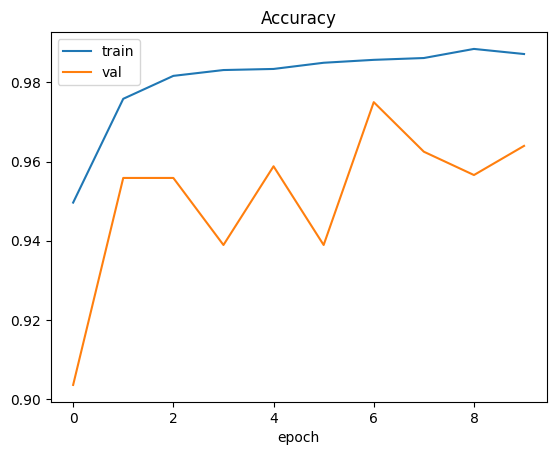

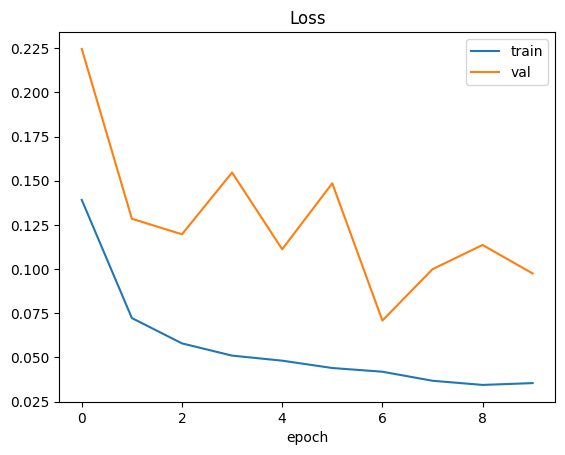

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation")

base = MobileNetV2(include_top=False, weights="imagenet",
                   input_shape=IMG_SIZE+(3,), pooling="avg")
base.trainable = False  # stage A: train head first

inputs = keras.Input(shape=IMG_SIZE+(3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base(x, training=False)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"),
             keras.metrics.Precision(name="prec"),
             keras.metrics.Recall(name="rec")]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("mobilenetv2_fresh_vs_rotten.keras",
                                    monitor="val_loss", save_best_only=True)
]

hist = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

# training curves
plt.figure(); plt.plot(hist.history["acc"]); plt.plot(hist.history["val_acc"]); plt.title("Accuracy"); plt.xlabel("epoch"); plt.legend(["train","val"]); plt.show()
plt.figure(); plt.plot(hist.history["loss"]); plt.plot(hist.history["val_loss"]); plt.title("Loss"); plt.xlabel("epoch"); plt.legend(["train","val"]); plt.show()


In [ ]:
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # lower LR for FT
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"),
             keras.metrics.Precision(name="prec"),
             keras.metrics.Recall(name="rec")]
)

hist_ft = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)


Epoch 1/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 88s 105ms/step - acc: 0.9008 - loss: 0.3512 - prec: 0.8607 - rec: 0.9682 - val_acc: 0.9838 - val_loss: 0.0521 - val_prec: 0.9819 - val_rec: 0.9896
Epoch 2/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - acc: 0.9379 - loss: 0.1975 - prec: 0.9095 - rec: 0.9789 - val_acc: 0.9853 - val_loss: 0.0486 - val_prec: 0.9934 - val_rec: 0.9805
Epoch 3/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - acc: 0.9485 - loss: 0.1419 - prec: 0.9217 - rec: 0.9858 - val_acc: 0.9816 - val_loss: 0.0546 - val_prec: 0.9960 - val_rec: 0.9714
Epoch 4/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 70s 100ms/step - acc: 0.9594 - loss: 0.1107 - prec: 0.9370 - rec: 0.9874 - val_acc: 0.9904 - val_loss: 0.0378 - val_prec: 0.9987 - val_rec: 0.9844
Epoch 5/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - acc: 0.9682 - loss: 0.0797 - prec: 0.9480 - rec: 0.9926 - val_acc: 0.9882 - val_loss: 0.0411 - val_prec: 0.9974 - val_rec: 0.9818
Epoch 6/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - acc: 0.974

86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - acc: 0.9986 - loss: 0.0061 - prec: 1.0000 - rec: 0.9973
Test metrics: {'acc': 0.997061014175415, 'loss': 0.009474383667111397, 'prec': 1.0, 'rec': 0.9948052167892456}
              precision    recall  f1-score   support

       fresh       0.99      1.00      1.00       591
      rotten       1.00      0.99      1.00       770

    accuracy                           1.00      1361
   macro avg       1.00      1.00      1.00      1361
weighted avg       1.00      1.00      1.00      1361



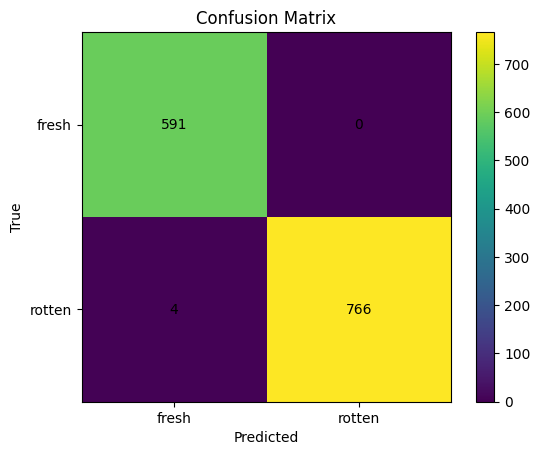

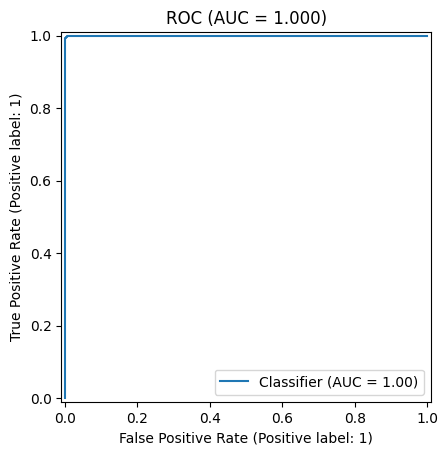

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

test_metrics = model.evaluate(test_ds, return_dict=True)
print("Test metrics:", test_metrics)

# predictions for detailed metrics
y_true, y_score = [], []
for xb, yb in test_ds:
    y_true.extend(yb.numpy().ravel())
    y_score.extend(model.predict(xb, verbose=0).ravel())
y_true = np.array(y_true); y_score = np.array(y_score)
y_pred = (y_score >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=["fresh","rotten"]))
cm = confusion_matrix(y_true, y_pred)

plt.figure();
plt.imshow(cm, interpolation='nearest'); plt.title("Confusion Matrix")
plt.xticks([0,1], ["fresh","rotten"]); plt.yticks([0,1], ["fresh","rotten"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar(); plt.show()

try:
    auc = roc_auc_score(y_true, y_score)
    RocCurveDisplay.from_predictions(y_true, y_score)
    plt.title(f"ROC (AUC = {auc:.3f})"); plt.show()
except Exception as e:
    print("ROC failed:", e)


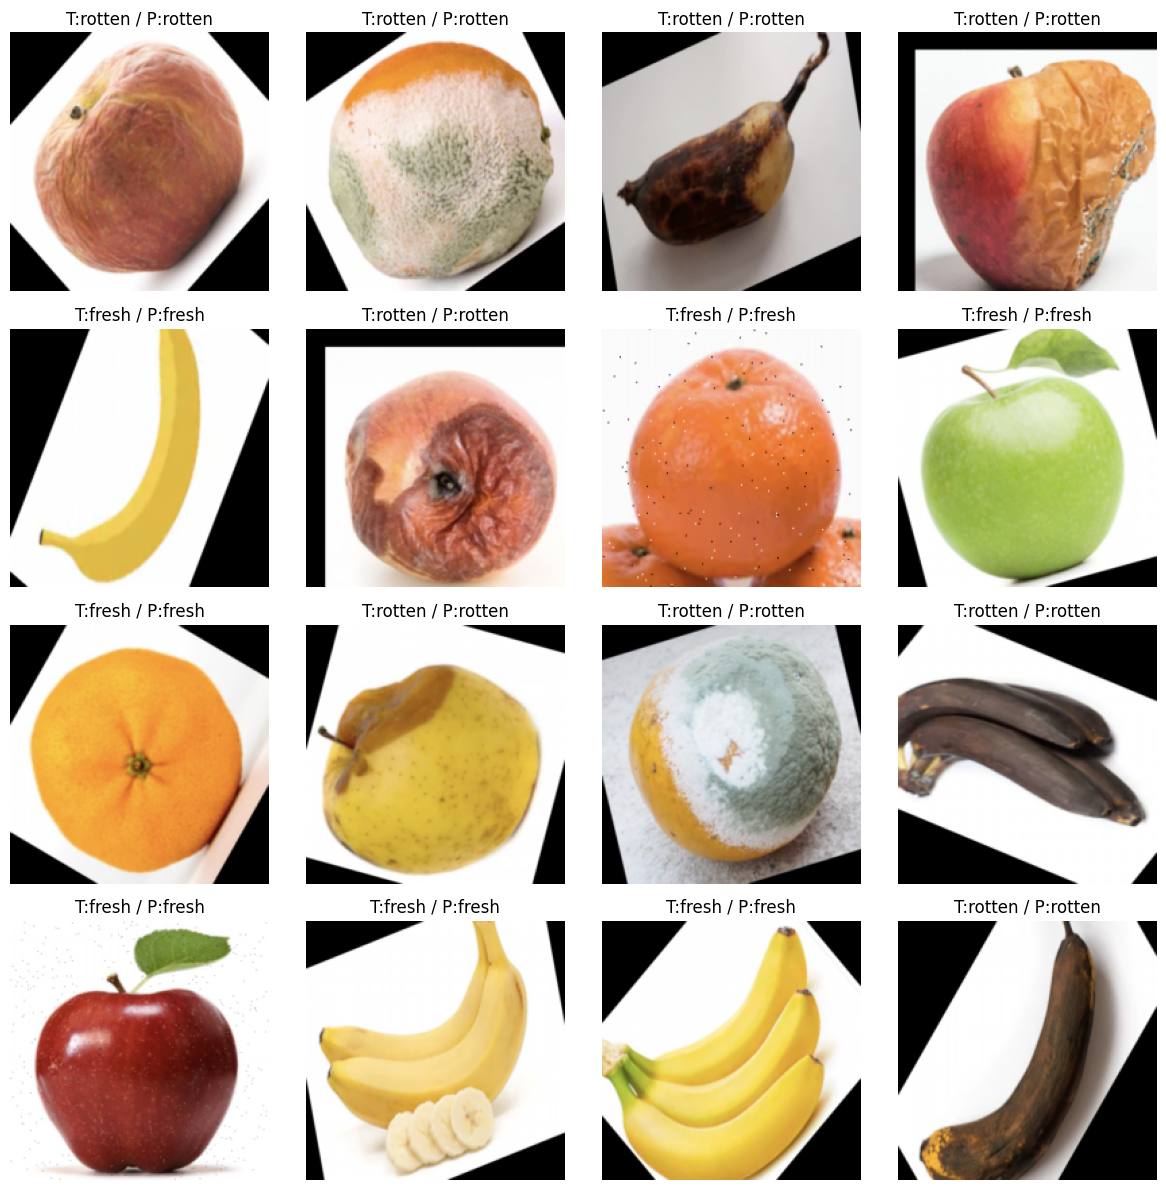

In [ ]:
xs, ys = [], []
for x, y in test_ds.unbatch().take(16):
    xs.append(x.numpy())
    y_np = y.numpy()
    y_scalar = float(y_np.reshape(-1)[0]) if hasattr(y_np, "reshape") else float(y_np)
    ys.append(y_scalar)

imgs = np.stack(xs).astype("uint8")
gts  = (np.array(ys) >= 0.5).astype(int)

probs = model.predict(imgs, verbose=0).ravel()
pred  = (probs >= 0.5).astype(int)

plt.figure(figsize=(12,12))
for i in range(len(imgs)):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i]); plt.axis("off")
    plt.title(f"T:{['fresh','rotten'][gts[i]]} / P:{['fresh','rotten'][pred[i]]}")
plt.tight_layout(); plt.show()